# Anemia en Diálisis Peritoneal

In [1]:
from lifelines import CoxPHFitter
from lifelines import CoxTimeVaryingFitter
import matplotlib.pyplot as plt
import pandas as pd

import anemiaLevanteDP as a

## Load Data

In [2]:
#file_path = ['/home/jovyan/work/Data/LevanteDP/LevanteDPC.xls']
file_path = ['/home/jovyan/work/Data/LevanteDP/LevanteDPC.xls', '/home/jovyan/work/Data/LevanteDP/LevanteDPPeset.xlsx']

# Load data from excel file
dfs_base = a.load_excel_files(file_path)
merged_df = a.merge_dataframes(dfs_base['Analíticas'], dfs_base['Pacientes'], 'REGISTRO')

# Save them as pickle for fast loading in testing
merged_df.to_pickle('merged_df.pkl')
dfs_base['Ingresos'].to_pickle('Ingresos.pkl')

In [3]:
# Load the data
merged_df = pd.read_pickle('merged_df.pkl')
dfs_base['Ingresos'] = pd.read_pickle('Ingresos.pkl')

## Preprocesado de datos

In [4]:
# Cols to calculate baseline
baseline_cat_cols = ['SEXO', 'CKD_STAGE', 'ARRITMIA', 'ITU', 'TBC', 'DM', 'VC', 'DIVERT', 'NEO', 'CH', 'SIST', 'EPOC', 'CARDIO', 'VP', 'DISLIPEMIA', 'DIURETICO', 'CALCIOANTA', 'IECA', 'ARAII', 'BBLOQUEANTE', 'ABLOQUEANTE', 'ABBLOQUEANTE', 'AGONISTASC', 'VASODILATADOR']
baseline_num_cols = ['EDAD', 'CKD_CALC', 'GLUCOSA', 'UREA', 'CREATININA', 'URICO', 'SODIO', 'POTASIO', 'CALCIO', 'FOSFORO', 'HIERRO', 'TRANSFERRINA', 'IST', 'FERRITINA', 'COLESTEROL', 'TRIGLICERIDOS', 'HDL', 'LDL', 'LEUCOCITOS', 'NEUTROFILOS', 'LINFOCITOS', 'MONOCITOS', 'EOSINOFILOS', 'BASOFILOS', 'GRANULOCITOS', 'HEMATIES', 'HEMOGLOBINA', 'HEMATOCRITO', 'VCM', 'HCM', 'CHCM', 'PLAQUETAS', 'PLAQUETOCRITO', 'VPM']

# Cols to clean rows without info
basic_cols_lab = ['REGISTRO', 'FECHA', 'HEMOGLOBINA', 'INICIO_DP']
basic_cols_hosp = ['REGISTRO', 'FINGRESO']
basic_cols_per = ['REGISTRO', 'FECHA']

# Cols for cox model
bool_col_list = ['CARDIORENAL', 'PASO_A_HD', 'ARRITMIA', 'ITU', 'TBC', 'DM', 'VC', 'DIVERT', 'NEO', 'CH', 'SIST', 'EPOC', 'CARDIO', 'VP', 'DISLIPEMIA', 'FRAGNOS', 'DIURETICO', 'CALCIOANTA', 'IECA', 'ARAII', 'BBLOQUEANTE', 'ABLOQUEANTE', 'ABBLOQUEANTE', 'AGONISTASC', 'VASODILATADOR', 'OTROSFR', 'CIRUGIA']
covariate_list = ['HEMOGLOBINA', 'IST', 'HIERRO', 'FERRITINA']
exclude_list = ['CARDIO']

In [5]:
# Clean NaNs for interesting columns
lab_df = a.clean_df(merged_df, basic_cols_lab, verbose=True)
lab_df = a.clean_df(lab_df, covariate_list, verbose=True)
hosp_df = a.clean_df(dfs_base['Ingresos'], basic_cols_hosp, verbose=True)
per_df = a.clean_df(dfs_base['Peritonitis'], basic_cols_per, verbose=True)

# Select years
lab_df, hosp_df, per_df = a.filter_by_year([lab_df, hosp_df, per_df], ['FECHA', 'FINGRESO', 'FECHA'], 2009, 2024)

# Add anemia column based on 'HEMOGLOBINA' and 'SEXO' specified in KDIGO guidelines
a.add_anemia_column(lab_df)
a.add_age_column(lab_df)
a.add_ckd_column(lab_df)

# Fill empty values for bool_cols
lab_df = a.bool_col_convert(lab_df, bool_col_list)

# Exclude patients with exclude_list
#lab_df = lab_df[lab_df['ICEDAD'] <= 11]
lab_df = a.exclude_patients(lab_df, exclude_list, verbose=True)

# Add days since the start of pd for every column in both dataframes
lab_df = a.add_days_since_start(lab_df, lab_df, 'FECHA')
hosp_df = a.add_days_since_start(lab_df, hosp_df, 'FINGRESO')
per_df = a.add_days_since_start(lab_df, per_df, 'FECHA')

# Now keep only the first year after the patients started PD
lab_df = a.filter_df(lab_df, 'days_since_start', 0, (365), verbose=True)
hosp_df = a.filter_df(hosp_df, 'days_since_start', 0, (365), verbose=True)
per_df = a.filter_df(per_df, 'days_since_start', 0, (365), verbose=True)

# Create the cox_df with all necessary data
cox_df = a.prepare_cox_df(lab_df, hosp_df, covariate_list)
cox_time_varying_df = a.cox_time_varying_prep(lab_df, hosp_df, covariate_list, 365)

cox_df_per = a.prepare_cox_df(lab_df, per_df, covariate_list)

The dataframe had 4747 rows (Unique patients: 470), after the clean up of missing values, it has 4617 rows (Unique patients: 467)
The dataframe had 4617 rows (Unique patients: 467), after the clean up of missing values, it has 4485 rows (Unique patients: 466)
The dataframe had 1028 rows (Unique patients: 472), after the clean up of missing values, it has 561 rows (Unique patients: 271)
The dataframe had 992 rows (Unique patients: 439), after the clean up of missing values, it has 983 rows (Unique patients: 434)
Rows before excluding patients: 4485
Rows after excluding patients: 2466
Percentage of deleted rows: 45.01672240802675%
Rows before filter: 2466 (Unique patients: 274)
Rows after filter: 1148 (Unique patients: 269)
Rows before filter: 185 (Unique patients: 99)
Rows after filter: 68 (Unique patients: 53)
Rows before filter: 202 (Unique patients: 105)
Rows after filter: 91 (Unique patients: 60)


## 6.1 Cox hemoglobina - hospitalización

<lifelines.CoxPHFitter: fitted with 269 total observations, 217 right-censored observations>
             duration col = 'finish_days'
                event col = 'event_col'
      baseline estimation = breslow
   number of observations = 269
number of events observed = 52
   partial log-likelihood = -278.13
         time fit was run = 2024-05-21 10:19:21 UTC

---
             coef exp(coef)  se(coef)  coef lower 95%  coef upper 95% exp(coef) lower 95% exp(coef) upper 95%
covariate                                                                                                    
HEMOGLOBINA -0.24      0.78      0.12           -0.49           -0.00                0.61                1.00
IST          0.04      1.04      0.03           -0.01            0.09                0.99                1.10
HIERRO      -0.03      0.97      0.01           -0.05           -0.00                0.95                1.00
FERRITINA    0.00      1.00      0.00           -0.00            0.00                1.00                1.00

             cmp to     z    p  -log2(p)
covariate                               
HEMOGLOBINA    0.00 -1.96 0.05      4.34
IST            0.00  1.56 0.12      3.09
HIERRO         0.00 -2.23 0.03      5.28
FERRITINA      0.00  0.91 0.36      1.46
---
Concordance = 0.64
Partial AIC = 564.27
log-likelihood ratio test = 15.03 on 4 df
-log2(p) of ll-ratio test = 7.75

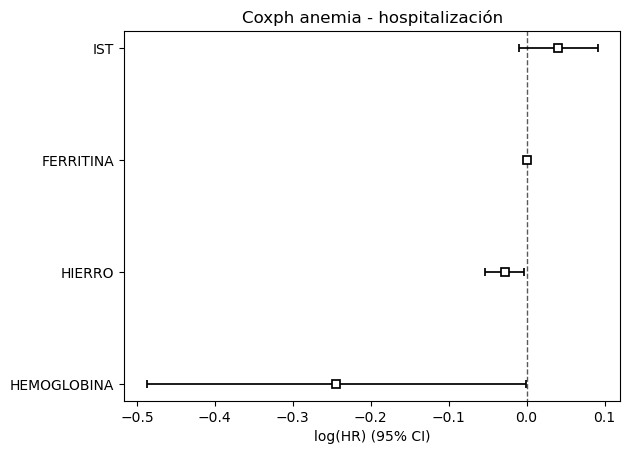

In [6]:
# Initialize the CoxPHFitter

cph_hosp = CoxPHFitter()

# Fit the data to the model
cph_hosp.fit(cox_df, duration_col='finish_days', event_col='event_col')

# Print the summary of the model
cph_hosp.print_summary()

# Plot the coefficients of the model
cph_hosp.plot()
plt.title('Coxph anemia - hospitalización')
plt.show()

In [7]:
a.calculate_residuals(cph_hosp, cox_df, martingale=True, schonenfeld=False)

Martingale Residuals:
      finish_days  event_col  martingale
211          3.0       True    0.994306
58           4.0       True    0.981882
62           7.0       True    0.986937
187         11.0       True    0.985651
220         12.0       True    0.902465
..           ...        ...         ...
264        365.0      False   -0.531504
265        365.0      False   -0.241303
266        365.0      False   -0.137086
267        365.0      False   -0.365291
268        365.0      False   -0.108359

[269 rows x 3 columns]


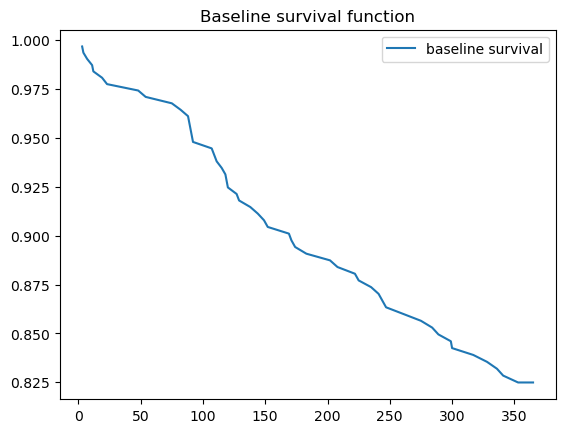

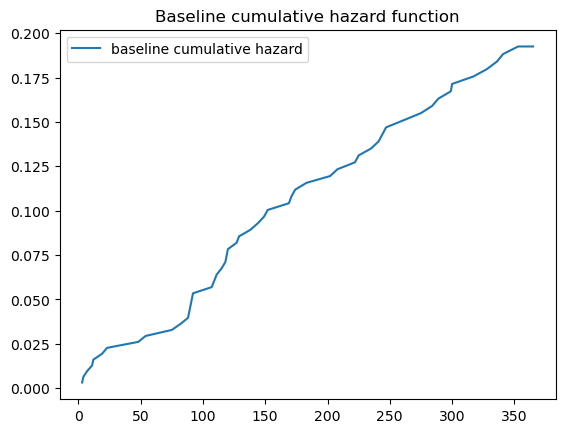


   Bootstrapping lowess lines. May take a moment...


   Bootstrapping lowess lines. May take a moment...


   Bootstrapping lowess lines. May take a moment...


   Bootstrapping lowess lines. May take a moment...

Proportional hazard assumption looks okay.


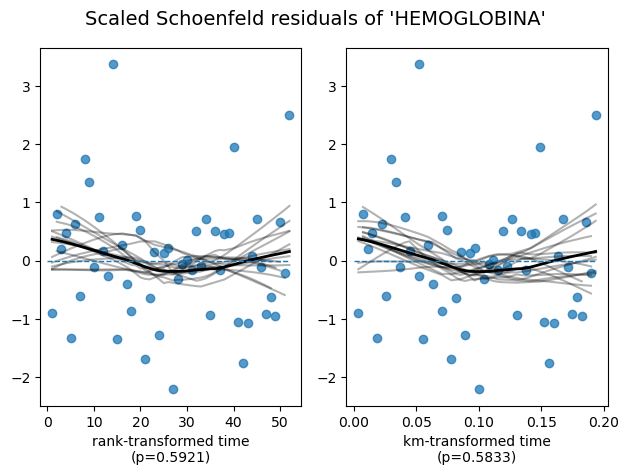

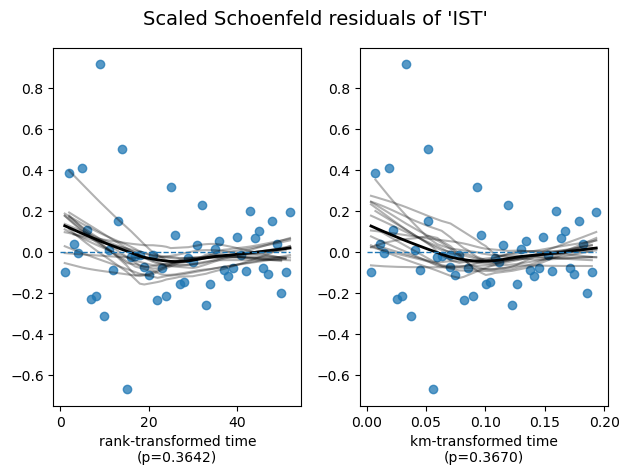

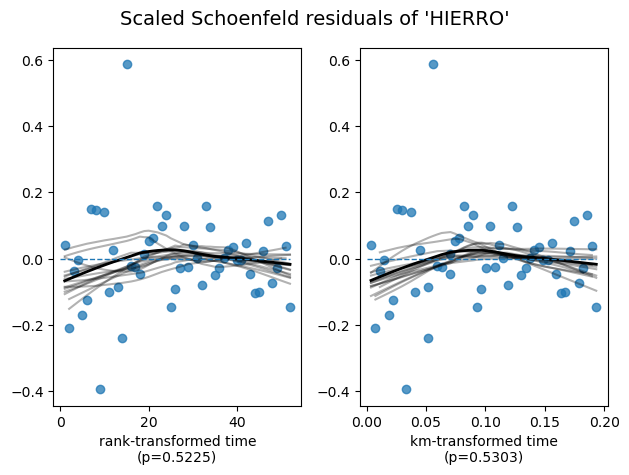

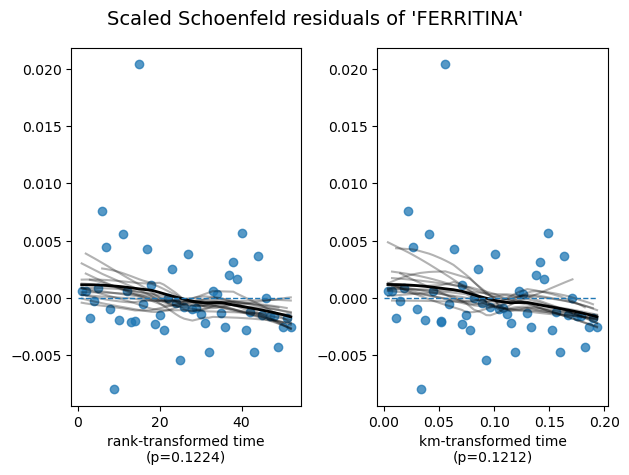

In [8]:
a.cox_visualization(cph_hosp, cox_df, survival_function=False, baseline_survival=True, baseline_cumulative_hazard=True, assumption=True) 

## 6.3 Cox hemoglobina - peritonitis

<lifelines.CoxPHFitter: fitted with 269 total observations, 209 right-censored observations>
             duration col = 'finish_days'
                event col = 'event_col'
      baseline estimation = breslow
   number of observations = 269
number of events observed = 60
   partial log-likelihood = -324.84
         time fit was run = 2024-05-21 10:19:22 UTC

---
             coef exp(coef)  se(coef)  coef lower 95%  coef upper 95% exp(coef) lower 95% exp(coef) upper 95%
covariate                                                                                                    
HEMOGLOBINA  0.00      1.00      0.11           -0.22            0.22                0.81                1.24
IST          0.06      1.06      0.02            0.02            0.10                1.02                1.11
HIERRO      -0.03      0.97      0.01           -0.05           -0.01                0.95                0.99
FERRITINA   -0.00      1.00      0.00           -0.00            0.00                1.00                1.00

             cmp to     z    p  -log2(p)
covariate                               
HEMOGLOBINA    0.00  0.01 0.99      0.01
IST            0.00  2.64 0.01      6.91
HIERRO         0.00 -2.62 0.01      6.84
FERRITINA      0.00 -0.70 0.48      1.05
---
Concordance = 0.58
Partial AIC = 657.68
log-likelihood ratio test = 7.43 on 4 df
-log2(p) of ll-ratio test = 3.12

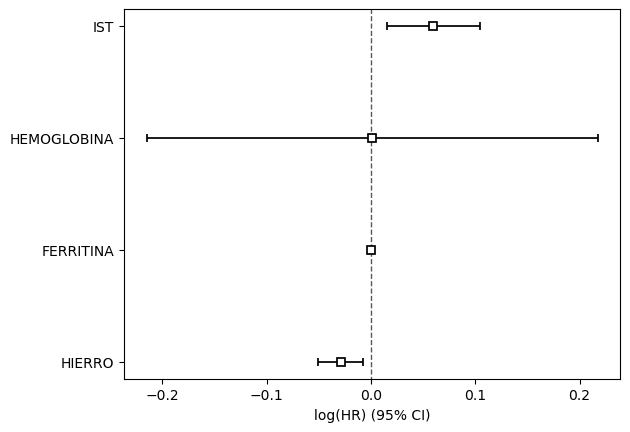

In [9]:
# Initialize the CoxPHFitter

cph_per = CoxPHFitter()

# Fit the data to the model
cph_per.fit(cox_df_per, duration_col='finish_days', event_col='event_col')

# Print the summary of the model
cph_per.print_summary()

# Plot the coefficients of the model
cph_per.plot()
plt.show()

In [10]:
a.calculate_residuals(cph_per, cox_df_per, martingale=True, schonenfeld=False)

Martingale Residuals:
      finish_days  event_col  martingale
267          5.0       True    0.995161
64          13.0       True    0.992998
112         19.0       True    0.986874
59          20.0       True    0.981849
264         34.0       True    0.977061
..           ...        ...         ...
260        365.0      False   -0.642404
261        365.0      False   -0.216545
263        365.0      False   -0.399468
265        365.0      False   -0.281249
268        365.0      False   -0.149343

[269 rows x 3 columns]


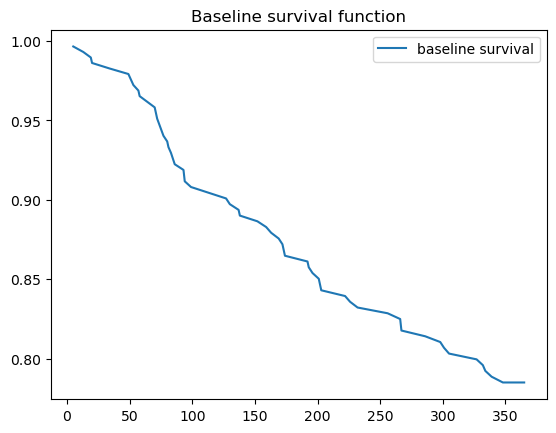

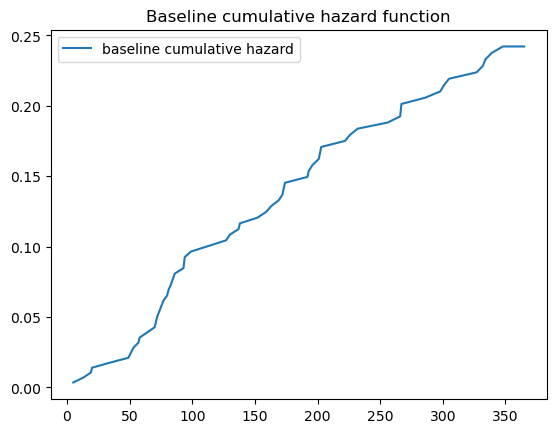


   Bootstrapping lowess lines. May take a moment...


   Bootstrapping lowess lines. May take a moment...


   Bootstrapping lowess lines. May take a moment...


   Bootstrapping lowess lines. May take a moment...

Proportional hazard assumption looks okay.


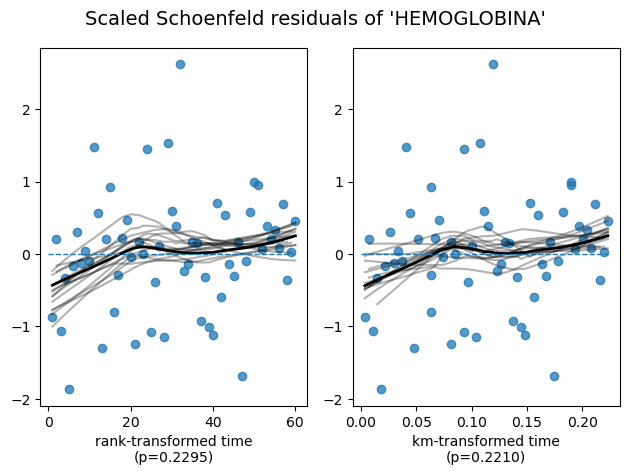

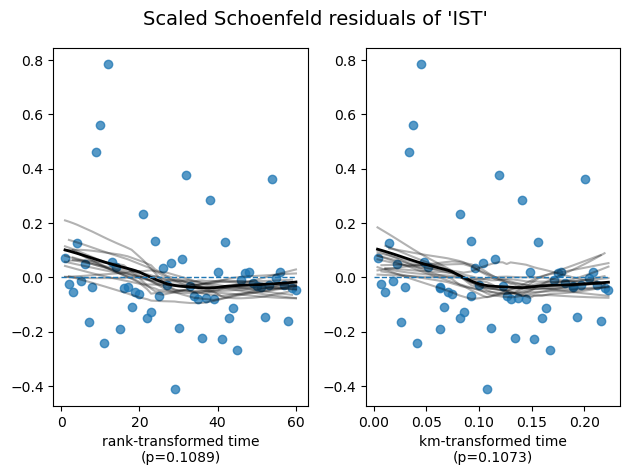

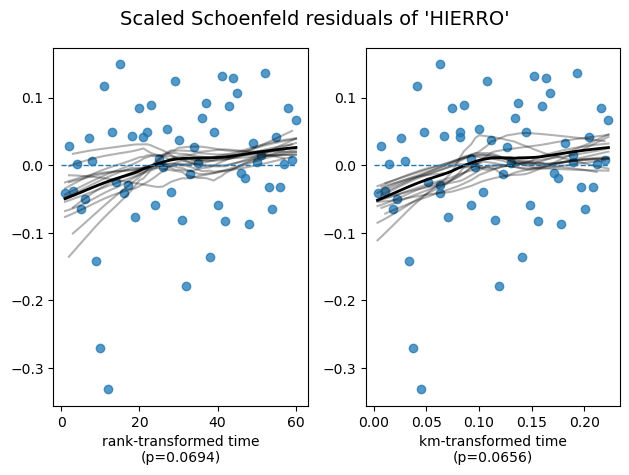

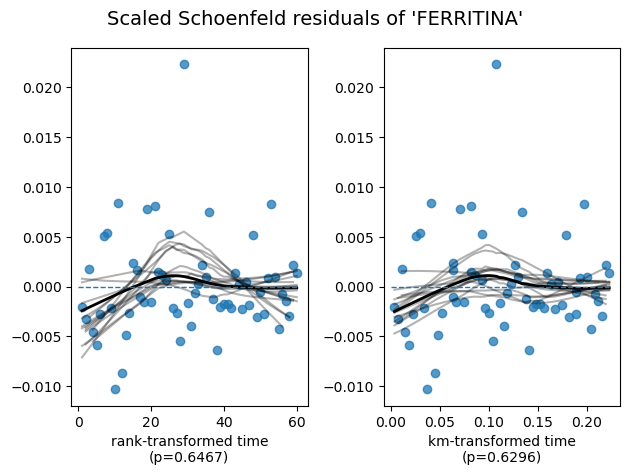

In [11]:
a.cox_visualization(cph_per, cox_df_per, survival_function=False, baseline_survival=True, baseline_cumulative_hazard=True, assumption=True) 

## Prevalencia de anemia en pacientes con ERC en DP

The dataframe had 4747 rows (Unique patients: 470), after the clean up of missing values, it has 4485 rows (Unique patients: 466)
Prevalencia anual de anemia:
2010: 75.0%
2011: 85.71%
2012: 85.11%
2013: 92.31%
2014: 91.67%
2015: 91.43%
2016: 91.11%
2017: 89.42%
2018: 86.84%
2019: 85.27%
2020: 85.48%
2021: 76.92%
2022: 79.57%
2023: 76.62%


/home/jovyan/work/Medicina/LevanteDPAnemia/anemiaLevanteDP.py:318: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  input_df['ANEMIA'] = input_df.apply(check_anemia, axis=1)


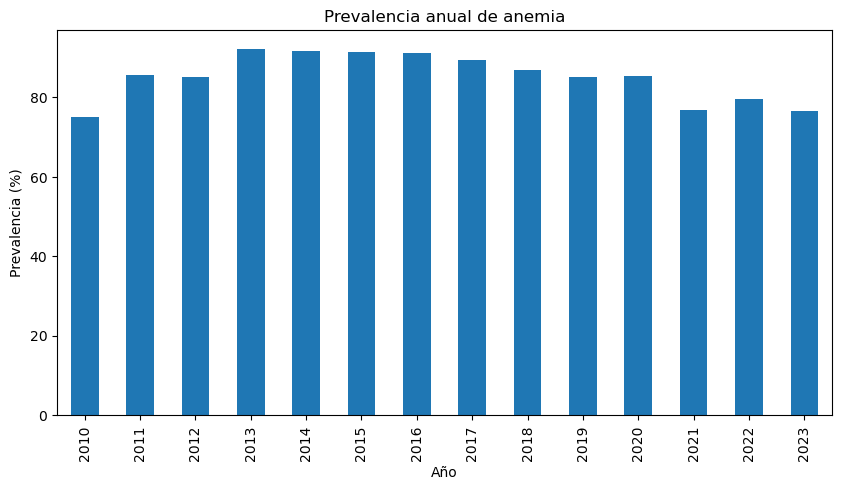

In [12]:
# Reload the full dataframe without filtering

anemia_cols = ['HEMOGLOBINA', 'HIERRO', 'IST', 'FERRITINA', 'REGISTRO', 'FECHA']
merged_df = pd.read_pickle('merged_df.pkl')
anemia_df = a.clean_df(merged_df, anemia_cols, verbose=True)
a.add_anemia_column(anemia_df)
anemia_df = a.filter_by_year([anemia_df], ['FECHA'], 2009, 2023)[0]
anemia_prevalence = a.anemia_prevalence(anemia_df, print_results=True, print_graph=True, tendency=True)

## Tendencias marcadores de anemia

In [13]:
# Calculate the average time between labs

time_between_labs = a.lab_freq_stats(anemia_df, print_avg=True, print_patient=False)

Global average time between tests = 64.74275792167931 days


HEMOGLOBINA: p-value = 0.6536136152161711
HIERRO: p-value = 0.08275985172908258
IST: p-value = 0.07048605940617311
FERRITINA: p-value = 0.46024927135887217
CKD_CALC: p-value = 0.5059664585403113


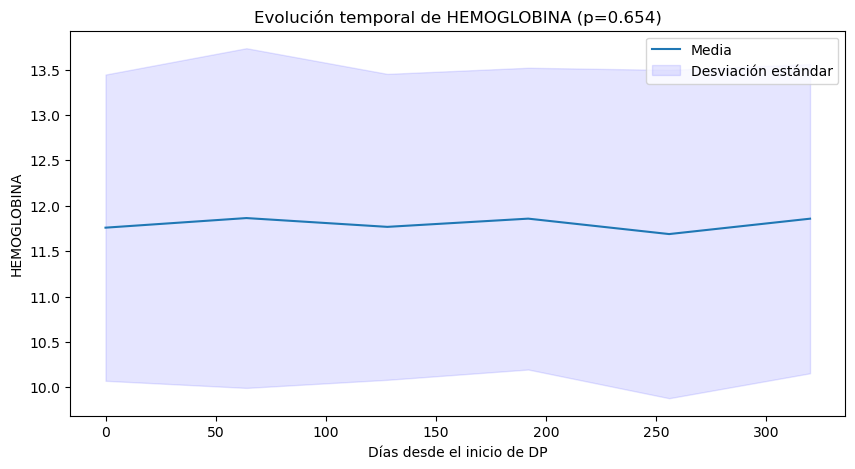

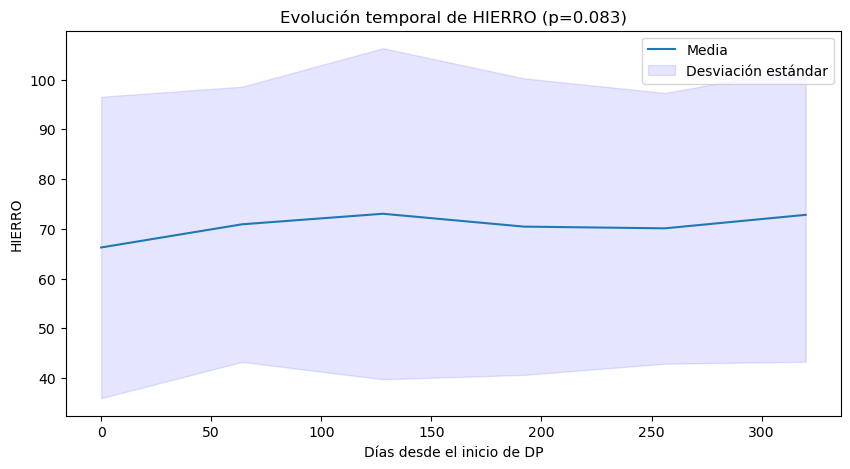

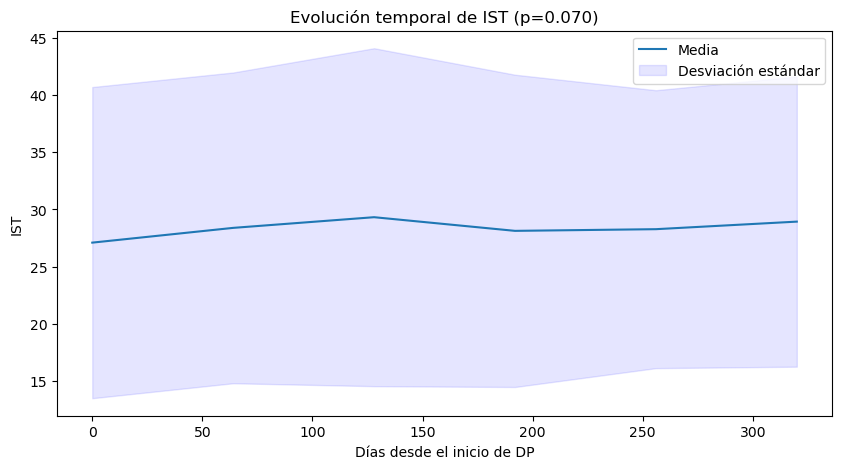

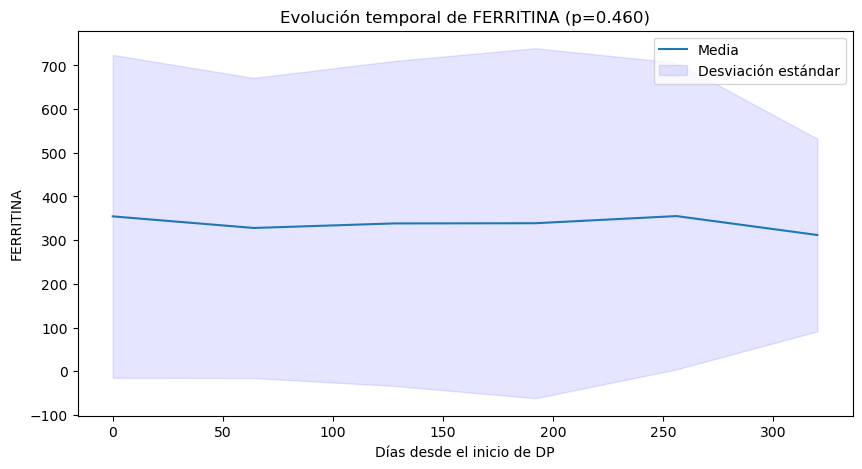

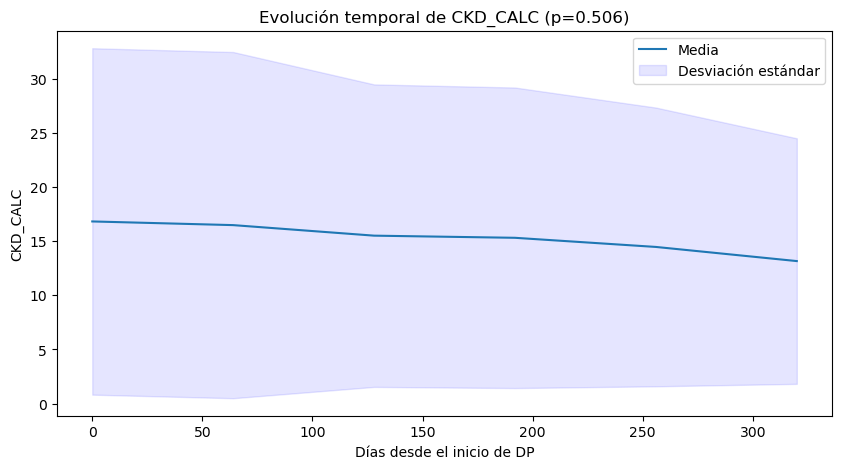

In [14]:
time_trend_cols = ['HEMOGLOBINA', 'HIERRO', 'IST', 'FERRITINA', 'CKD_CALC']

a.add_age_column(anemia_df)
a.add_ckd_column(anemia_df)

time_trend_df = a.time_trend_analysis(anemia_df, 64, time_trend_cols, 365, plot_results=True, t_test=True)

In [15]:
a.stationary_test(time_trend_df, col_str='_avg')

Testing for stationarity in column: HEMOGLOBINA_avg
ADF Statistic: -5.538036
p-value: 0.000002
Critical Values:
	1%: -6.045
	5%: -3.929
	10%: -2.987
The data in HEMOGLOBINA_avg is stationary.

Testing for stationarity in column: HIERRO_avg
ADF Statistic: -3.716279
p-value: 0.003890
Critical Values:
	1%: -7.355
	5%: -4.474
	10%: -3.127
The data in HIERRO_avg is stationary.

Testing for stationarity in column: IST_avg
ADF Statistic: -19.632088
p-value: 0.000000
Critical Values:
	1%: -7.355
	5%: -4.474
	10%: -3.127
The data in IST_avg is stationary.

Testing for stationarity in column: FERRITINA_avg
ADF Statistic: -3.421312
p-value: 0.010253
Critical Values:
	1%: -6.045
	5%: -3.929
	10%: -2.987
The data in FERRITINA_avg is stationary.

Testing for stationarity in column: CKD_CALC_avg
ADF Statistic: 1.054768
p-value: 0.994811
Critical Values:
	1%: -6.045
	5%: -3.929
	10%: -2.987
The data in CKD_CALC_avg is not stationary and may need differencing.



In [16]:
print(time_trend_df)

   HEMOGLOBINA_avg  HEMOGLOBINA_std  HIERRO_avg  HIERRO_std    IST_avg  \
0        11.758114         1.686436   66.252193   30.303882  27.099342   
1        11.863910         1.870601   70.909774   27.663573  28.390476   
2        11.767039         1.684707   73.030726   33.274626  29.324302   
3        11.857576         1.661824   70.445455   29.812459  28.129697   
4        11.687629         1.807890   70.099656   27.221575  28.276289   
5        11.857085         1.702658   72.813765   29.535113  28.937247   

     IST_std  FERRITINA_avg  FERRITINA_std  CKD_CALC_avg  CKD_CALC_std  
0  13.609054     354.478070     369.687251     16.823402     16.002306  
1  13.591398     327.929825     343.501070     16.483658     15.991376  
2  14.780292     338.346369     372.041567     15.510376     13.973115  
3  13.658731     338.787879     400.625731     15.312320     13.882347  
4  12.155423     355.154639     351.080372     14.467935     12.876014  
5  12.688913     311.834008     220.526073 

## Baseline

In [17]:
baseline = a.calculate_baseline(lab_df, baseline_cat_cols, baseline_num_cols)
a.print_baseline(baseline)

SEXO:
    counts: SEXO
1. Hombre    185
2. Mujer      84
Name: count, dtype: int64
    percentages: SEXO
1. Hombre    68.773234
2. Mujer     31.226766
Name: count, dtype: float64

CKD_STAGE:
    counts: CKD_STAGE
Stage 5     250
Stage 4      16
Stage 3B      3
Name: count, dtype: int64
    percentages: CKD_STAGE
Stage 5     92.936803
Stage 4      5.947955
Stage 3B     1.115242
Name: count, dtype: float64

ARRITMIA:
    counts: ARRITMIA
False            247
True              18
Missing_value      4
Name: count, dtype: int64
    percentages: ARRITMIA
False            91.821561
True              6.691450
Missing_value     1.486989
Name: count, dtype: float64

ITU:
    counts: ITU
False            144
Missing_value    120
True               5
Name: count, dtype: int64
    percentages: ITU
False            53.531599
Missing_value    44.609665
True              1.858736
Name: count, dtype: float64

TBC:
    counts: TBC
False            149
Missing_value    120
Name: count, dtype: int64
    p